In [241]:
import numpy as np
import pandas as pd
import os
import pickle
import sys
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
sys.path.append('/Users/ramtinyazdanian/PycharmProjects/job_skill_trend_analysis/')
from utilities.common_utils import *
from utilities.analysis_utils import *
from utilities.pandas_utils import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
from scipy.stats import shapiro, anderson, probplot
from scipy import stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [242]:
root_data_path = '/Users/ramtinyazdanian/Downloads/jobtech/'
all_filenames = os.listdir(root_data_path)
all_dataframes = [pd.read_csv(os.path.join(root_data_path,filename)) 
                  for filename in all_filenames if filename[-3:] == 'csv' and filename[0] != '~']

In [243]:
df_all = pd.concat(all_dataframes)

In [244]:
df_all.head()

,jobId,jobUrl,jobTitle,jobDescription,datePosted,companyId,companyName,industryId,yoxMin,yoxMax,finalWageMin,finalWageMax,countryCode,skills,qualifications
0,0023502d439415ad8bbdb62a7020114c0e67ed5824e0b6...,https://sg.jobsdb.com/job/rd/adbd75e33b3a1415d...,Admin & Accounts Executive,Roles &amp; ResponsibilitiesJob Description<br...,2020-01-01,4a536df3d73f2123c14b4a1d5fa6b8ecfd9352b3c390f1...,MILWORKS SOLUTIONS PTE. LTD.,InfoComm Technologies,0,0,1150.0,1917.0,SG,"[{'skill': 'accounts payable accounting', 'ski...",['Bachelors']
1,0053799fde5277b3ee431bb57f0820ef01a4c6abf7246d...,https://sg.jobsdb.com/job/rd/adbd75e33b3a1415d...,Admin & Accounts Executive,Roles &amp; ResponsibilitiesJob Description<br...,2020-01-01,4a536df3d73f2123c14b4a1d5fa6b8ecfd9352b3c390f1...,MILWORKS SOLUTIONS PTE. LTD.,InfoComm Technologies,0,0,1150.0,1917.0,SG,"[{'skill': 'accounts payable accounting', 'ski...",['Bachelors']
2,009bd6514108fed114208aa85c28a2c318291978e301ee...,https://sg.jobsdb.com/job/rd/adbd75e33b3a1415d...,Admin & Accounts Executive,Roles &amp; ResponsibilitiesJob Description<br...,2020-01-01,4a536df3d73f2123c14b4a1d5fa6b8ecfd9352b3c390f1...,MILWORKS SOLUTIONS PTE. LTD.,InfoComm Technologies,0,0,1150.0,1917.0,SG,"[{'skill': 'accounts payable accounting', 'ski...",['Bachelors']
3,00edb53a28e215cfb3f8d90594fac0872919bba772d842...,https://sg.jobsdb.com/job/rd/adbd75e33b3a1415d...,Admin & Accounts Executive,Roles &amp; ResponsibilitiesJob Description<br...,2020-01-01,4a536df3d73f2123c14b4a1d5fa6b8ecfd9352b3c390f1...,MILWORKS SOLUTIONS PTE. LTD.,InfoComm Technologies,0,0,1150.0,1917.0,SG,"[{'skill': 'accounts payable accounting', 'ski...",['Bachelors']
4,01103f9a143bdecf5e09484315bd1a2fb36fe9e7acbca6...,https://sg.jobsdb.com/job/rd/adbd75e33b3a1415d...,Admin & Accounts Executive,Roles &amp; ResponsibilitiesJob Description<br...,2020-01-01,4a536df3d73f2123c14b4a1d5fa6b8ecfd9352b3c390f1...,MILWORKS SOLUTIONS PTE. LTD.,InfoComm Technologies,0,0,1150.0,1917.0,SG,"[{'skill': 'accounts payable accounting', 'ski...",['Bachelors']


In [245]:
df_all.industryId.unique()

array(['InfoComm Technologies'], dtype=object)

In [246]:
df_all_useful_cols = df_all[['companyName', 'industryId', 'datePosted', 'skills']].rename(columns={
    'companyName': 'Company', 'industryId': 'Industry', 'datePosted': 'Date', 'skills': 'Skill List'
})

df_all_useful_cols['Skill List'] = df_all_useful_cols['Skill List'].apply(eval)
df_all_useful_cols['Date'] = pd.to_datetime(df_all_useful_cols['Date'])
company_totals = divide_into_periods(df_all_useful_cols, ['Company'], result_col_name='Total')

df_all_useful_cols = explode(df_all_useful_cols, ['Skill List'])
df_all_useful_cols = df_all_useful_cols.loc[df_all_useful_cols['Skill List'].apply(lambda x: x != '')]

df_all_useful_cols['Skill'] = df_all_useful_cols['Skill List'].apply(lambda x: x['skill'])
df_all_useful_cols['Skill Type'] = df_all_useful_cols['Skill List'].apply(lambda x: x['skillTypeId'])
df_all_useful_cols = df_all_useful_cols.drop(columns='Skill List')

In [247]:
df_all_useful_cols.head()

,Company,Date,Industry,Skill,Skill Type
0,MILWORKS SOLUTIONS PTE. LTD.,2020-01-01,InfoComm Technologies,accounts payable accounting,2
1,Red Hat,2018-01-01,InfoComm Technologies,virtualization technology,1
2,KEYREPLY PTE. LTD.,2019-01-03,InfoComm Technologies,account management,2
3,KEYREPLY PTE. LTD.,2019-01-03,InfoComm Technologies,business development,1
4,KEYREPLY PTE. LTD.,2019-01-03,InfoComm Technologies,communication,4


In [420]:
company_totals.sum()

Company    01 Computer System Pte Ltd01 Computer System P...
Total                                                  37413
dtype: object

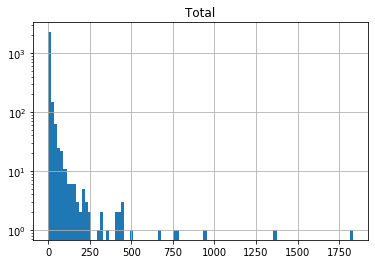

In [425]:
company_totals.groupby('Company').sum().hist(bins=100)
plt.yscale('log')

In [427]:
company_totals['year'] = company_totals.Date.apply(lambda x: x.year)
company_totals.groupby('year').sum()

,Total
year,
2017,4516
2018,9915
2019,17835
2020,5147


If we want to filter out the irrelevant skill types (which I need to figure out), here is the place.

In [248]:
df_all_useful_cols['Skill Type'].unique()

array([2, 1, 4, 3])

In [249]:
df_all_useful_cols.loc[df_all_useful_cols['Skill Type'] == 1].groupby('Skill').count().\
            sort_values('Date', ascending=False).index.values.tolist()

['computer science',
 'cloud technology',
 'regulatory compliance',
 'sops/best practices',
 'consulting',
 'unix/linux',
 'hardware',
 'information technology',
 'business finance',
 'business development',
 'microsoft windows os',
 'web services',
 'social media (facebook)',
 'legal/law',
 'computer engineering',
 'data center',
 'telecommunications',
 'social media',
 'healthcare',
 'operating systems',
 'supply chain & logistics',
 'scrum/agile',
 'amazon web services',
 'information systems',
 'e-commerce',
 'virtualization technology',
 'web applications',
 'sdlc',
 'advertising',
 'software-as-a-service (saas)',
 'investment',
 'open source technology',
 'vmware',
 'manufacturing',
 'system engineering',
 'genetic information',
 'continuous improvement',
 'human resource development',
 'b2b engagement',
 'business administration',
 'machine learning algorithms',
 'compensation & benefits',
 'artificial intelligence',
 'iso',
 'big data',
 'marketing strategy',
 'cyber security',

Skill type 3 is languages and licenses, 4 is general soft skills.

Types 1 and 2 are both hard skills, the difference being that type 1 deals with more generic skills and with clusters, while 2 deals with specific technology for the most part.

In [250]:
absolute_start = np.datetime64('2017-01-01')
absolute_end = np.datetime64('2020-01-01')

In [251]:
it_skills = set(pd.read_csv('./it_skills.csv').Skill.values)

In [252]:
it_skills

{'apache ibatis',
 'universal mobile telecommunications service (umts)',
 'network administration',
 'bluetooth',
 'flask (python)',
 'testng',
 'control-m',
 'backbone.js',
 'oracle database',
 'sap sd',
 'invision',
 'mailchimp',
 'anti-spam programming',
 'sdk',
 'continuous improvement',
 'scip',
 'togaf',
 'automation solution',
 'standard template library (c++)',
 'macromedia dreamweaver',
 'numpy',
 'online banking',
 'logical architecture',
 'video processing',
 'travis ci',
 'project management',
 'quantum computing',
 'publishing',
 'mes (manufacturing execution system)',
 'service oriented architecture',
 'microsoft office 365',
 'xsl',
 'ibm infosphere datastage',
 'webpack',
 'blockchain technology',
 'caffe',
 'xamarin',
 'interaction design (ixd)',
 'zigbee',
 'c',
 'dynamic host configuration protocol',
 'google bigtable',
 'wi-fi protected setup',
 'logstash',
 'apache spark',
 'customer relationship management',
 'apache struts',
 'bigquery',
 'financial audit',
 'roo

In [253]:
skills_df = divide_into_periods(df_all_useful_cols.loc[(df_all_useful_cols['Skill Type'] == 1) | 
                                                       (df_all_useful_cols['Skill Type'] == 2)], 
                                ['Company', 'Skill'], 
                                absolute_start, absolute_end, result_col_name='Job Postings Raw')
skills_df = pd.merge(skills_df, company_totals, on = ['Company', 'Date'])
skills_df['Job Postings'] = skills_df['Job Postings Raw'] / skills_df['Total']
skills_df = skills_df.loc[skills_df.Skill.apply(lambda x: x in it_skills)]

In [254]:
skills_df.sort_values('Date').head(10)

,Company,Skill,Date,Job Postings Raw,Total,Job Postings
175670,Sapura Synergy Singapore Pte Ltd,microsoft windows os,2017-01-01,2,3,0.666667
7127,ARETE M PTE. LTD.,vmware,2017-01-01,1,3,0.333333
189852,Tivo Technologies Pte Ltd,virtual private network,2017-01-01,1,1,1.000000
189853,Tivo Technologies Pte Ltd,wide area network configuration,2017-01-01,1,1,1.000000
179320,Solarwinds Software Asia Pte Ltd,general algorithms,2017-01-01,1,7,0.142857
189122,Third Sight Pte Ltd,swot analysis,2017-01-01,1,2,0.500000
189120,Third Sight Pte Ltd,project management,2017-01-01,1,2,0.500000
189115,Third Sight Pte Ltd,multi-task,2017-01-01,1,2,0.500000
189113,Third Sight Pte Ltd,economics,2017-01-01,1,2,0.500000
7126,ARETE M PTE. LTD.,version control,2017-01-01,1,3,0.333333


In [255]:
len(skills_df.Skill.unique())

1021

In [256]:
# skills_df[['Skill']].drop_duplicates().sort_values('Skill').to_csv('./all_skills.csv')

## Computing the true emerging skills

In [257]:
monthly_totals = compute_total_values(skills_df)
total_log = compute_total_log_mean(skills_df)

In [258]:
start_and_end_dates = [(np.datetime64('2018-01-01'), np.datetime64('2019-01-01')), 
                       (np.datetime64('2019-01-01'), np.datetime64('2020-01-01')),
                       (np.datetime64('2018-01-01'), np.datetime64('2020-01-01'))]

# start_and_end_dates = [(np.datetime64('2017-01-01'), np.datetime64('2018-01-01')), 
#                        (np.datetime64('2017-01-01'), np.datetime64('2019-01-01')), 
#                        (np.datetime64('2018-01-01'), np.datetime64('2019-01-01')), 
#                        (np.datetime64('2019-01-01'), np.datetime64('2020-01-01')),
#                        (np.datetime64('2018-01-01'), np.datetime64('2020-01-01')),
#                        (np.datetime64('2017-01-01'), np.datetime64('2020-01-01'))]

total_values = [get_period_of_time(monthly_totals, start_and_end_dates[i][0], start_and_end_dates[i][1]).sum()[0]
                for i in range(len(start_and_end_dates))]

In [662]:
skill_trends = [logsum_trend_slope_wrapper(skills_df, 
                                                  start_and_end_dates[i][0], start_and_end_dates[i][1],
                                                  total_log, nologtest=False) 
                                for i in range(len(start_and_end_dates))]

Start: 2018-01-01
End: 2019-01-01
Number of skills: 875
            Slope   Intercept  Acceleration   Spikiness
count  875.000000  875.000000    875.000000  875.000000
mean    -0.356669    2.543225      0.046578    1.184162
std      0.870844    7.173510      0.106852   10.924431
min     -8.555570   -1.101713     -0.067819  -99.347098
25%     -0.376286   -0.377756      0.001323   -0.726162
50%     -0.140862    0.146351      0.015520    1.499593
75%      0.004662    1.828030      0.043438    2.519283
max      1.164774   65.103199      1.006078  204.404138
Start: 2019-01-01
End: 2020-01-01
Number of skills: 944
            Slope   Intercept  Acceleration   Spikiness
count  944.000000  944.000000    944.000000  944.000000
mean     0.579642    3.612500     -0.047230    1.532591
std      1.721871    9.401600      0.135907   28.807575
min     -1.677732   -1.209868     -1.495257 -158.643975
25%     -0.118663   -0.375598     -0.048180   -0.460763
50%      0.076755    0.314653     -0.007373    1

In [663]:
skill_trends[1].sort_values('Slope', ascending=False).head(20)

,Slope,Intercept,Acceleration,Spikiness,Job Postings Raw
Skill,,,,,
computer science,18.706938,80.170087,-1.495257,1.451331,3867
general programming,14.387940,79.534560,-1.268802,1.418444,2909
documentation,13.060453,52.592032,-0.864141,1.401512,2224
project management,12.807720,78.718540,-1.034039,1.351869,3004
hardware,11.354142,27.398035,-0.738651,1.448615,1633
cloud technology,10.782356,68.632416,-0.770289,1.330726,3157
coordination,9.977492,68.755284,-0.614336,1.328484,2499
information technology,9.788236,25.597081,-0.602512,1.566657,1558
java,9.504010,42.710768,-0.835049,1.491297,1528


In [664]:
skill_trends[2].corr(method='pearson')

,Slope,Intercept,Acceleration,Spikiness,Job Postings Raw
Slope,1.000000,0.591188,-0.799583,-0.009988,0.816927
Intercept,0.591188,1.000000,-0.043223,0.004796,0.927254
Acceleration,-0.799583,-0.043223,1.000000,0.008371,-0.338076
Spikiness,-0.009988,0.004796,0.008371,1.000000,-0.002309
Job Postings Raw,0.816927,0.927254,-0.338076,-0.002309,1.000000


In [665]:
skill_trends[2].corr(method='spearman')

,Slope,Intercept,Acceleration,Spikiness,Job Postings Raw
Slope,1.000000,0.081434,-0.840848,0.352068,0.623719
Intercept,0.081434,1.000000,0.130084,0.293345,0.648881
Acceleration,-0.840848,0.130084,1.000000,-0.199551,-0.342998
Spikiness,0.352068,0.293345,-0.199551,1.000000,0.520362
Job Postings Raw,0.623719,0.648881,-0.342998,0.520362,1.000000


In [673]:
emerging_skills = [threshold_logsum_trends_simple(skill_trends[i], total=total_values[i], col='Slope', 
                                                  only_positives=True,
                                                  col_percentile_thresh=.6, pop_lower=0.001, pop_upper=0.01) 
                        for i in range(len(skill_trends))]

In [674]:
emerging_skills[0]

,Skill,Slope,Intercept,Acceleration,Spikiness,Job Postings Raw
0,a/b testing,0.196057,-0.559056,-0.006522,6.029260,19
1,adobe creative suite,0.372734,-0.025944,-0.019596,2.623853,43
2,android studio,0.166941,-0.288385,-0.015741,-26.906519,12
3,apache impala,0.156884,-0.583694,-0.009716,-7.311967,11
4,apache web server,0.370225,-0.478117,-0.037797,-28.466174,15
...,...,...,...,...,...,...
67,tensorflow,0.512569,0.043675,-0.022969,2.170559,56
68,user experience evaluation,0.348184,0.082479,-0.018816,2.966704,37
69,video analytics,0.188647,-0.010406,-0.016085,3.566869,24
70,web design,0.764414,-0.328144,-0.067819,3.058378,30


In [675]:
compare_emerging_skill_sets(emerging_skills, start_and_end_dates, sort_type='alpha')


Comparing 2018-01-01 to 2019-01-01 with 2019-01-01 to 2020-01-01

# of skills shared and exclusive to each date (in order)
14 58 66

The skills themselves:

Shared:

['adobe creative suite', 'data migration', 'data quality control', 'enterprise web architecture', 'full stack development', 'graphic design', 'java message service', 'microsoft office 365', 'network systems', 'practical malware analysis', 'react native', 'system testing', 'tensorflow', 'web design']

Exclusive to 2018-01-01 to 2019-01-01

['a/b testing', 'android studio', 'apache impala', 'apache web server', 'api integration', 'application security design', 'architecture', 'asr', 'aveva', 'bgp (border gateway protocol)', 'bootstrap', 'building management system', 'ceph', 'cloudera', 'containerization (web)', 'crystal reports', 'data communications', 'data migration strategy', 'database optimisation', 'e-mail marketing', 'eloqua', 'endpoint security', 'gradle', 'hlr database', 'keras', 'less (stylesheet language)', 'long-

### Evaluating the sets of trending skills based on known (and obvious) ground truth

In [676]:
ground_truth_base = pd.DataFrame({'Skill': 
                    ['vue.js', 'deep learning', 'tensorflow', 'kubernetes', 'graphql', 'cryptocurrency',
                     'redux', 'apache kafka', 'salesforce lightning', 'aws lambda', 'aws redshift', 'domo',
                     'data lakes', 'serverless computing', 'blockchain technology', 'amazon aurora', 
                     'docker', 'looker', 'autonomous cars', 'financial microservices', 'microservices',
                     'data visualisation', 'apache hive', 'apache hadoop', 'apache flume', 'apache kafka', 
                     'predictive models',
                     ]})

In [677]:
compute_prec_recall(emerging_skills[0], ground_truth_base)

{'redux', 'tensorflow'}
2 72 27


(0.027777777777777776, 0.07407407407407407, 0.0404040404040404)

In [678]:
compute_prec_recall(emerging_skills[1], ground_truth_base)

{'tensorflow', 'deep learning', 'apache kafka'}
3 80 27


(0.0375, 0.1111111111111111, 0.056074766355140186)

In [679]:
compute_prec_recall(emerging_skills[2], ground_truth_base)

{'cryptocurrency', 'apache kafka', 'tensorflow', 'redux', 'graphql', 'deep learning', 'vue.js', 'blockchain technology', 'apache hive', 'data visualisation'}
10 123 27


(0.08130081300813008, 0.37037037037037035, 0.13333333333333333)

### Looking at a few skills that don't show up in 2019

In [596]:
skill_trends[1].loc[skill_trends[1].Slope > 0].quantile(0.5)

Slope                0.384835
Intercept            0.689253
Acceleration        -0.032422
Spikiness            1.592577
Job Postings Raw    49.000000
Name: 0.5, dtype: float64

In [597]:
skill_trends[1].loc[skill_trends[1].Slope > 0].quantile(0.7)

Slope                 0.892566
Intercept             3.901865
Acceleration         -0.014727
Spikiness             2.009027
Job Postings Raw    146.000000
Name: 0.7, dtype: float64

In [598]:
total_values[1]

17517

In [599]:
skill_trends[1].loc['kubernetes']

Slope                 0.953609
Intercept             8.043812
Acceleration         -0.064278
Spikiness             1.308548
Job Postings Raw    245.000000
Name: kubernetes, dtype: float64

In [600]:
skill_trends[1].loc['deep learning']

Slope                 0.986974
Intercept             4.696374
Acceleration         -0.093421
Spikiness             1.739360
Job Postings Raw    147.000000
Name: deep learning, dtype: float64

In [601]:
skill_trends[1].loc['tensorflow']

Slope                 1.365964
Intercept             2.221338
Acceleration         -0.115262
Spikiness             1.835885
Job Postings Raw    125.000000
Name: tensorflow, dtype: float64

In [602]:
skill_trends[1].loc['keras']

Slope                0.354214
Intercept            0.189203
Acceleration        -0.014007
Spikiness            1.880134
Job Postings Raw    50.000000
Name: keras, dtype: float64

In [506]:
skill_trends[1].loc['vue.js']

Slope               -0.171590
Intercept            4.421292
Acceleration         0.000000
Spikiness            1.806726
Job Postings Raw    81.000000
Name: vue.js, dtype: float64

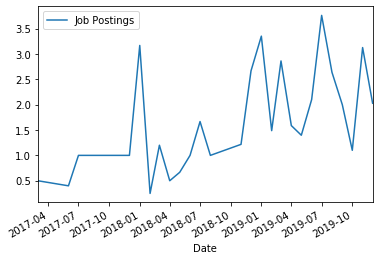

In [604]:
skills_df.loc[skills_df.Skill == 'vue.js', ['Date', 'Job Postings']].groupby('Date').sum().plot()

## Looking at the distributions of computed quantities

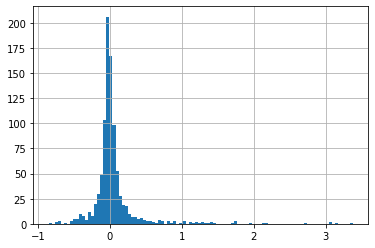

In [311]:
skill_trends[1].Slope.hist(bins=100)
#plt.yscale('log')

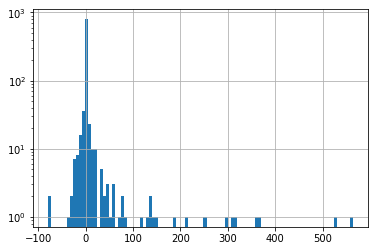

In [312]:
skill_trends[1].Acceleration.hist(bins=100)
plt.yscale('log')

In [313]:
skill_trends[2].Slope.quantile(.8), \
            skill_trends[2].Slope.quantile(.9), skill_trends[2].Slope.mean() 

(0.18853788605771754, 0.4540857426221441, 0.16925235633056387)

Interestingly, as this plot and the summary statistics show, the Slope values are way more skewed to the right here, and the Generalised Normals that we had used before will fail.

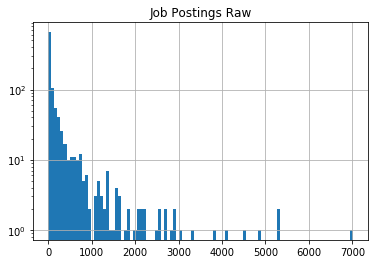

In [314]:
skills_df[['Skill', 'Job Postings Raw']].groupby('Skill').sum().\
                        hist(bins = 100)
plt.yscale('log')

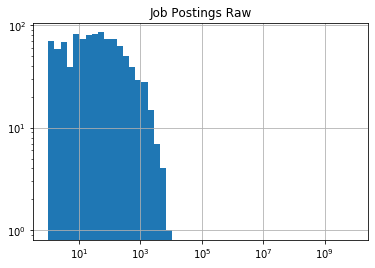

In [315]:
skills_df[['Skill', 'Job Postings Raw']].groupby('Skill').sum().\
                        hist(bins = np.logspace(np.log(1), np.log(20000), 50))
plt.yscale('log')
plt.xscale('log')

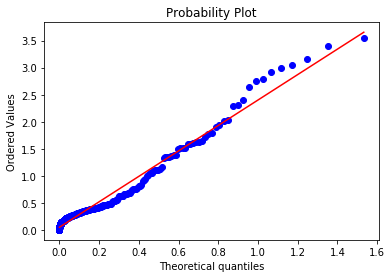

In [357]:
probplot(skill_trends[0].loc[skill_trends[0].Slope > 0].Slope.values, dist=stats.gengamma, 
         sparams=(.05,2.3), fit=True, plot=plt)
plt.show()

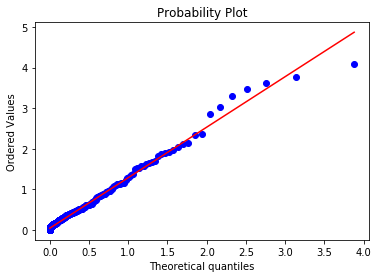

In [317]:
probplot(skill_trends[2].loc[skill_trends[2].Slope > 0].Slope.values, dist=stats.gamma, 
         sparams=(.16), fit=True, plot=plt)
plt.show()

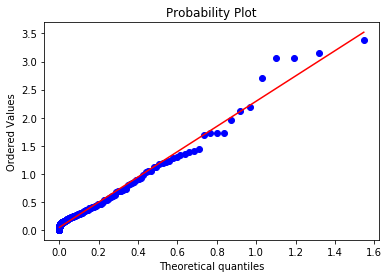

In [364]:
probplot(skill_trends[1].loc[skill_trends[1].Slope > 0].Slope.values, dist=stats.gengamma, 
         sparams=(.05,2), fit=True, plot=plt)
plt.show()

Generally, it's safe to say that the slope values generally follow two back to back Gamma distributions, one for the positives and one for the negatives. We don't really care about the negatives (because they're the _declining_ skills, while we're only interested in the growing skills), meaning that we can just discard the negatives and fit a Gamma to the positives.

The mean and variance of this distribution are equal to the shape parameter, which makes it very interesting: it's a distribution with faster than exponential decay, meaning that even the mean can be pretty restrictive!

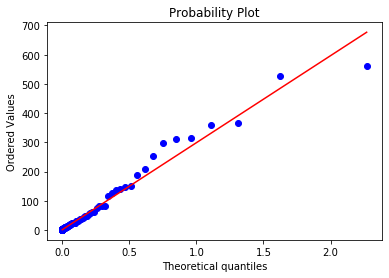

In [319]:
probplot(skill_trends[1].loc[skill_trends[1].Acceleration > 0].Acceleration.values, dist=stats.gamma, 
         sparams=(.04), fit=True, plot=plt)
plt.show()

The acceleration is a Gamma if we remove the very extreme outliers, but with _extremely low_ shape parameters.

((array([1.25872199e-32, 8.93609453e-29, 9.48406085e-27, ...,
         2.58908578e+00, 2.95898131e+00, 3.68341721e+00]),
  array([   1,    1,    1, ..., 5290, 5316, 7007])),
 (1902.9077669547485, 29.714987997810482, 0.9975883055328315))

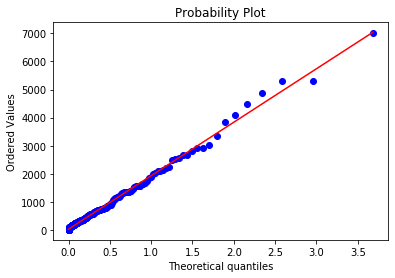

In [366]:
probplot(skills_df[['Skill', 'Job Postings Raw']].groupby('Skill').sum()['Job Postings Raw'].values, 
         dist=stats.gamma, 
         sparams=(.1), fit=True, plot=plt)

## Analysis with companies